In [2]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# GMMのギブスサンプリング版でライブラリ
from scipy.stats import multivariate_normal, wishart, dirichlet # 多次元ガウス分布, ウィシャート分布, ディリクレ分布

# GMMのパラメータのギブスサンプリングによる推定推定

教科書 4.4.2節を参考に、人工的に生成したデータを用いて、GMMのパラメータをギブスサンプリングより推定します。

コード元：https://www.anarchive-beta.com/entry/2021/01/01/194939

## 真のモデルの設定

In [5]:
# 次元数を設定:(固定)
D = 2

# クラスタ数を指定
K = 3

# K個の真の平均を指定
mu_truth_kd = np.array(
    [[5.0, 35.0], 
     [-20.0, -10.0], 
     [30.0, -20.0]]
)

# K個の真の共分散行列を指定
sigma2_truth_kdd = np.array(
    [[[250.0, 65.0], [65.0, 270.0]], 
     [[125.0, -45.0], [-45.0, 175.0]], 
     [[210.0, -15.0], [-15.0, 250.0]]]
)

# 真の混合比率を指定（各値は0以上で、合計は1になること）
pi_truth_k = np.array([0.45, 0.25, 0.3])

# 確認
print("mu", mu_truth_kd)
print("sigma", sigma2_truth_kdd)
print ("pi", pi_truth_k)


mu [[  5.  35.]
 [-20. -10.]
 [ 30. -20.]]
sigma [[[250.  65.]
  [ 65. 270.]]

 [[125. -45.]
  [-45. 175.]]

 [[210. -15.]
  [-15. 250.]]]
pi [0.45 0.25 0.3 ]


In [6]:
# 作図用のx軸のxの値を作成 (K個のクラスタそれぞれで平均値±3標準偏差を計算して、その最小値から最大値までを範囲とする)
x_1_line = np.linspace(
    np.min(mu_truth_kd[:, 0] - 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    np.max(mu_truth_kd[:, 0] + 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    num=300
)

# 作図用のy軸のxの値を作成 (K個のクラスタそれぞれで平均値±3標準偏差を計算して、その最小値から最大値までを範囲とする)
x_2_line = np.linspace(
    np.min(mu_truth_kd[:, 1] - 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    np.max(mu_truth_kd[:, 1] + 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    num=300
)

# 確率密度を等高線図にする際に格子状の点(2軸の全ての値が直交する点)を渡す必要があるため、作図用の格子状の点を作成する。する。
# x_1_lineとx_2_lineの要素の全ての組み合わせを持つような2次元配列に変換している。
x_1_grid, x_2_grid = np.meshgrid(x_1_line, x_2_line)

# x_1_grid, x_2_gridの要素を列として持つ2次元配列を作成をし、作図用のxの点とする。
x_point = np.stack([x_1_grid.flatten(), x_2_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存：
# 計算結果の確率密度は1次元配列になり、作図時にx_1_grid, x_2_gridと同じ形状にする必要があるため、形状をx_dimとして保存
x_dim = x_1_grid.shape
print("x_dim", x_dim)

# 確認：1列目がx軸の値、2列目がy軸の値に対応しています。
print("x_point", x_point[:5]) 

x_dim (300, 300)
x_point [[-53.54101966 -67.4341649 ]
 [-53.11621983 -67.4341649 ]
 [-52.69142    -67.4341649 ]
 [-52.26662017 -67.4341649 ]
 [-51.84182033 -67.4341649 ]]


In [7]:
# 観測モデルの確率密度を計算
# K個のパラメータmu_truth_kd, sigmga2_truth_ddkを使って、x_point_matの点ごとに、次の混合ガウス分布の式で確率密度を計算
true_model = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(x=x_point, mean=mu_truth_kd[k], cov=sigma2_truth_kdd[k])
    
    # K個の分布の加重平均を計算
    true_model += pi_truth_k[k] * tmp_density


# 確認
print(true_model[:5])

[9.06768334e-13 1.07345258e-12 1.27033352e-12 1.50260830e-12
 1.77630256e-12]


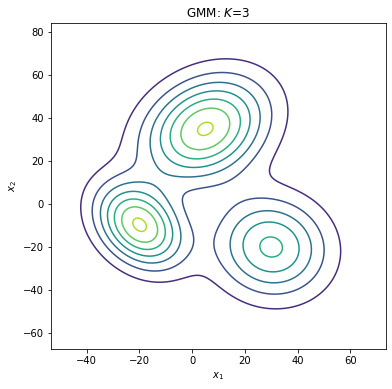

In [8]:
# 観測モデルを作図
plt.figure(figsize=(6, 6))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim)) # 真の分布
plt.title('GMM: $K$=' + str(K))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## 構築した真のモデルから観測データを生成

先に、潜在変数を生成し、各データにクラスタを割り当てます。次に、割り当てられたクラスタに従い観測データを生成します。

In [9]:
# 生成する観測データ数を指定
N = 250

# 潜在変数を生成
s_truth_nk = np.random.multinomial(n=1, pvals=pi_truth_k, size=N)

# 確認：各行がデータを表し、値が1の列番号が割り当てられたクラスタ番号を表す one-hot ベクトルになっている。
print(s_truth_nk[:5])

[[0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [10]:
# s_truth_nkから、np.where()を使って行(データ)ごとに要素が1の列番号を、各データのクラスタ番号として、抽出
_, s_truth_n = np.where(s_truth_nk == 1)

# 確認
print(s_truth_n[:5])

[2 0 0 0 0]


In [11]:
# 各データに割り当てられたクラスタに従いN個のデータを生成

# (観測)データを生成
x_nd = np.array([
    # 多次元ガウス分布のランダムサンプリングを、np.random.multivariate_normal()でおこなっている
    np.random.multivariate_normal(mean=mu_truth_kd[k], cov=sigma2_truth_kdd[k], size=1).flatten() for k in s_truth_n
])

# 確認
print(x_nd[:5])

[[ 15.26981593   0.50211785]
 [-19.85544849  14.49733537]
 [  0.69618467  35.21460929]
 [-17.27956284  47.20607157]
 [ -3.11393543  40.78695067]]


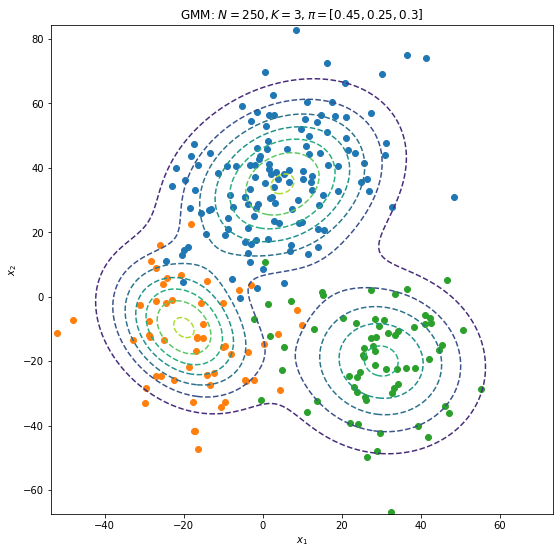

In [12]:
# モデルに観測データの散布図を重ねて表示
plt.figure(figsize=(9, 9))
for k in range(K):
    k_idx, = np.where(s_truth_n == k) # クラスタkのデータのインデック
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # 観測データ
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), linestyles='--') # 真の分布
plt.title('GMM: $N=' + str(N) + ', K=' + str(K) + 
          ', \pi=[' + ', '.join([str(pi) for pi in pi_truth_k]) + ']$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [14]:
# 基礎課題5-1と同様 note12-2などに用いるため、主要なパラメータや変数をJSONファイルとして保存する。
# 参考 https://codechacha.com/ja/python-read-write-json-file/
# 保存する変数の型を確認
print (type(D), D, type(K), K, type(N), N, type(pi_truth_k), pi_truth_k.ndim, type(mu_truth_kd), mu_truth_kd.ndim)
print (type(sigma2_truth_kdd), sigma2_truth_kdd.shape, type(s_truth_nk), s_truth_nk.shape, type(s_truth_n), s_truth_n.shape, type(x_nd), x_nd.shape)

# 辞書型に保存する情報を集める
json_data = {'D': D,
             'K': K,
             'N': N,
             'pi_truth_k': pi_truth_k.tolist(), #list型へ変換
             'mu_truth_kd': mu_truth_kd.tolist(), # list型へ変換
             'sigma2_truth_kdd': sigma2_truth_kdd.reshape([1,-1]).tolist(), # 行と列がある場合は reshape を使い変形する。 [n, -1] を指定するとn×m (mは配列の要素数に合わせた値)の配列を返す。
             's_truth_nk': s_truth_nk.reshape([1,-1]).tolist(),
             's_truth_n': s_truth_n.reshape([1,-1]).tolist(),
             'x_nd': x_nd.reshape([1,-1]).tolist(),
             }
#print (json_data)

# 辞書型の変数の内容を JSON 形式で保存する。いつものように pd.DataFrame でCSV保存でもできないことはないが、パラメータをどう管理するのかが面倒なのでなので辞書型の変数の内容ををJSON形式で保存している。
import json
with open(output_dir + 'note12-1_output.json', 'w') as json_file:
  json.dump(json_data, json_file, ensure_ascii=False, indent=4) # インデントを4として保存

<class 'int'> 2 <class 'int'> 3 <class 'int'> 250 <class 'numpy.ndarray'> 1 <class 'numpy.ndarray'> 2
<class 'numpy.ndarray'> (3, 2, 2) <class 'numpy.ndarray'> (250, 3) <class 'numpy.ndarray'> (250,) <class 'numpy.ndarray'> (250, 2)


## 観測データから各データのクラスタを推定

### 事前分布を設定

次に、観測モデル(観測データの分布)と潜在変数の分布に対する共役事前分布を設定します。多次元ガウス分布のパラメータに対する事前分布としてガウス・ウィシャート分布、カテゴリ分布のパラメータ
に対する事前分布としてディリクレ分布
を設定します。

In [15]:
# muの事前分布のパラメータを指定
beta = 1.0
m_d = np.repeat(0.0, D)

# lambdaの事前分布のパラメータを指定
w_dd = np.identity(D) * 0.0005
nu = D

# piの事前分布のパラメータを指定
alpha_k = np.repeat(2.0, K)

In [16]:
# muの事前分布の標準偏差を計算
sigma_mu_d = np.sqrt(np.linalg.inv(beta * nu * w_dd).diagonal())

# 作図用のx軸のmuの値を作成
mu_0_line = np.linspace(
    np.min(mu_truth_kd[:, 0]) - sigma_mu_d[0], 
    np.max(mu_truth_kd[:, 0]) + sigma_mu_d[0], 
    num=300
)

# 作図用のy軸のmuの値を作成
mu_1_line = np.linspace(
    np.min(mu_truth_kd[:, 1]) - sigma_mu_d[1], 
    np.max(mu_truth_kd[:, 1]) + sigma_mu_d[1], 
    num=300
)

# 作図用の格子状の点を作成
mu_0_grid, mu_1_grid = np.meshgrid(mu_0_line, mu_1_line)

# 作図用のmuの点を作成
mu_point = np.stack([mu_0_grid.flatten(), mu_1_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存
mu_dim = mu_0_grid.shape
print(mu_dim)

(300, 300)


In [17]:
# muの事前分布を計算
prior_mu_density = multivariate_normal.pdf(x=mu_point, mean=m_d, cov=np.linalg.inv(beta * nu * w_dd))

# 確認
print(prior_mu_density[:5])

[1.10780663e-05 1.12959859e-05 1.15165400e-05 1.17397162e-05
 1.19655008e-05]


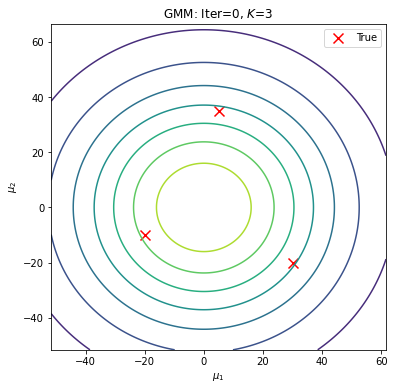

In [18]:
# muの事前分布を作図
plt.figure(figsize=(6, 6))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='True', color='red', s=100, marker='x') # 真の平均
plt.contour(mu_0_grid, mu_1_grid, prior_mu_density.reshape(mu_dim)) # 事前分布
plt.title('GMM: Iter=' + str(0) + ', $K$=' + str(K))
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.legend()
plt.show()

In [19]:
# 観測モデルのパラメータをサンプル
mu_kd = np.empty((K, D))
lambda_kdd = np.empty((K, D, D))
for k in range(K):
    # クラスタkの精度行列をサンプル
    lambda_kdd[k] = wishart.rvs(df=nu, scale=w_dd, size=1)
    
    # クラスタkの平均をサンプル
    mu_kd[k] = np.random.multivariate_normal(
        mean=m_d, cov=np.linalg.inv(beta * lambda_kdd[k])
    ).flatten()

# 確認
print(mu_kd)
print(lambda_kdd)

[[ -4.82289292 -72.43952885]
 [185.2123106   37.7989161 ]
 [-50.42455409 -31.54826736]]
[[[ 0.00095618  0.00012576]
  [ 0.00012576  0.00059204]]

 [[ 0.00016848 -0.0002935 ]
  [-0.0002935   0.00128606]]

 [[ 0.0031614  -0.00109093]
  [-0.00109093  0.00054636]]]


In [20]:
# 混合比率をサンプル：ディリクレ分布に従う乱数は、SciPyライブラリの のdirichlet.rvs()で生成できます。パラメータの引数alphaにalpha_kを指定します。2次元配列で出力されるため、flatten()で1次元配列に変換しておきます。
pi_k = dirichlet.rvs(alpha=alpha_k, size=1).flatten()

# 確認
print(pi_k)
print(np.sum(pi_k))

[0.35030135 0.55568798 0.09401068]
0.9999999999999999


In [21]:
# 初期値による混合分布を計算
init_density = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(
        x=x_point, mean=mu_kd[k], cov=np.linalg.inv(beta * lambda_kdd[k])
    )
    
    # K個の分布の加重平均を計算
    init_density += pi_k[k] * tmp_density

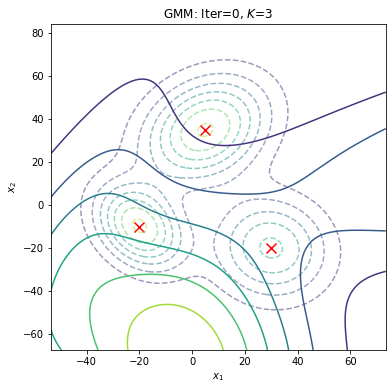

In [22]:
# 初期値による分布を作図
plt.figure(figsize=(6, 6))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='True', color='red', s=100, marker='x') # 真の平均
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), alpha=0.5, linestyles='dashed') # 真の分布
plt.contour(x_1_grid, x_2_grid, init_density.reshape(x_dim)) # 初期値による分布
plt.title('GMM: Iter=' + str(0) + ', $K$=' + str(K))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## ギブスサンプリング

In [23]:
# 試行回数を指定
MaxIter = 150

# パラメータを初期化
eta_nk = np.zeros((N, K))
s_nk = np.zeros((N, K))
beta_hat_k = np.zeros(K)
m_hat_kd = np.zeros((K, D))
w_hat_kdd = np.zeros((K, D, D))
nu_hat_k = np.zeros(K)
alpha_hat_k = np.zeros(K)

# 推移の確認用の受け皿を作成
trace_s_in = [np.repeat(np.nan, N)]
trace_mu_ikd = [mu_kd.copy()]
trace_lambda_ikdd = [lambda_kdd.copy()]
trace_pi_ik = [pi_k.copy()]
trace_beta_ik = [np.repeat(beta, K)]
trace_m_ikd = [np.repeat(m_d.reshape((1, D)), K, axis=0)]
trace_w_ikdd = [np.repeat(w_dd.reshape((1, D, D)), K, axis=0)]
trace_nu_ik = [np.repeat(nu, K)]
trace_alpha_ik = [alpha_k.copy()]

# ギブスサンプリング
for i in range(MaxIter):
    
    # 潜在変数の事後分布のパラメータを計算:式(4.94)
    for k in range(K):
        tmp_eta_n = np.diag(
            -0.5 * (x_nd - mu_kd[k]).dot(lambda_kdd[k]).dot((x_nd - mu_kd[k]).T)
        ).copy() # (何故か書き替え禁止になるのを防ぐためのcopy())
        # 以下、対数の計算において ln 0 とならないように、微小な値1e-7を加える
        tmp_eta_n += 0.5 * np.log(np.linalg.det(lambda_kdd[k]) + 1e-7)
        tmp_eta_n += np.log(pi_k[k] + 1e-7)
        eta_nk[:, k] = np.exp(tmp_eta_n)

    eta_nk /= np.sum(eta_nk, axis=1, keepdims=True) # データごとの和が1となるように正規化
    
    # eta_nkを用いて潜在変数Sをサンプル：式(4.93)
    # データによってパラメータ(各クラスタの割り当て確率)が異なるため、for文で1データずつ生成している
    for n in range(N):
        s_nk[n] = np.random.multinomial(n=1, pvals=eta_nk[n], size=1).flatten()
    
    # K個のクラスタのパラメータ mu, lambda, piを更新
    for k in range(K):

        # muの事後分布のパラメータを計算：式(4.99)
        beta_hat_k[k] = np.sum(s_nk[:, k]) + beta # μ_kの条件付き分布(多次元ガウス分布)の精度行列パラメータ 
        m_hat_kd[k] = np.sum(s_nk[:, k] * x_nd.T, axis=1)
        m_hat_kd[k] += beta * m_d
        m_hat_kd[k] /= beta_hat_k[k] # μ_kの条件付き分布(多次元ガウス分布)の平均パラメータ
        # print(beta_hat_k) # 確認
        # print(m_hat_kd) # 確認

        # lambdaの事後分布のパラメータを計算：式(4.103)
        tmp_w_dd = np.dot((s_nk[:, k] * x_nd.T), x_nd)
        tmp_w_dd += beta * np.dot(m_d.reshape(D, 1), m_d.reshape(1, D))
        tmp_w_dd -= beta_hat_k[k] * np.dot(m_hat_kd[k].reshape(D, 1), m_hat_kd[k].reshape(1, D))
        tmp_w_dd += np.linalg.inv(w_dd) 
        w_hat_kdd[k] = np.linalg.inv(tmp_w_dd) # lambda_k の条件付き分布(ウィシャート分布)のパラメータ
        nu_hat_k[k] = np.sum(s_nk[:, k]) + nu # 自由度
        # print(w_hat_kdd) # 確認
        # print(nu_hat_k) # 確認

        # パラメータw_hat_ddkと自由度nu_hat_kを持つウィシャート分布から、新たなlambdaをサンプル：式(4.102)
        lambda_kdd[k] = wishart.rvs(size=1, df=nu_hat_k[k], scale=w_hat_kdd[k])
        # print(lambda_kdd[k]) # 確認

        # 平均m_hat_kd, 精度行列 beta_hat_kとlambda_ddkの積をnp.linalg.inv()で逆行列に変換し分散共分散行列とする、多次元ガウス分布からmuをサンプル：式(4.98)
        mu_kd[k] = np.random.multivariate_normal(mean=m_hat_kd[k], cov=np.linalg.inv(beta_hat_k[k] * lambda_kdd[k]), size=1).flatten()
    
    # 混合比率のパラメータの条件付き分布のパラメータを計算：式(4.45)
    alpha_hat_k = np.sum(s_nk, axis=0) + alpha_k
    # print(alpha_hat_k)# 確認
    
    # alpha_hat_kを用いて、ディリクレ分布から新たなpiをサンプリング：式(4.44)
    pi_k = dirichlet.rvs(size=1, alpha=alpha_hat_k).flatten()
    # print(pi_k) # 確認
    # print(np.sum(pi_k)) # 確認
    
    # 値を記録
    _, s_n = np.where(s_nk == 1)
    trace_s_in.append(s_n.copy())
    trace_mu_ikd.append(mu_kd.copy())
    trace_lambda_ikdd.append(lambda_kdd.copy())
    trace_pi_ik.append(pi_k.copy())
    trace_beta_ik.append(beta_hat_k.copy())
    trace_m_ikd.append(m_hat_kd.copy())
    trace_w_ikdd.append(w_hat_kdd.copy())
    trace_nu_ik.append(nu_hat_k.copy())
    trace_alpha_ik.append(alpha_hat_k.copy())
    
    # 動作確認
    print(str(i + 1) + ' (' + str(np.round((i + 1) / MaxIter * 100, 1)) + '%)')

1 (0.7%)
2 (1.3%)
3 (2.0%)
4 (2.7%)
5 (3.3%)
6 (4.0%)
7 (4.7%)
8 (5.3%)
9 (6.0%)
10 (6.7%)
11 (7.3%)
12 (8.0%)
13 (8.7%)
14 (9.3%)
15 (10.0%)
16 (10.7%)
17 (11.3%)
18 (12.0%)
19 (12.7%)
20 (13.3%)
21 (14.0%)
22 (14.7%)
23 (15.3%)
24 (16.0%)
25 (16.7%)
26 (17.3%)
27 (18.0%)
28 (18.7%)
29 (19.3%)
30 (20.0%)
31 (20.7%)
32 (21.3%)
33 (22.0%)
34 (22.7%)
35 (23.3%)
36 (24.0%)
37 (24.7%)
38 (25.3%)
39 (26.0%)
40 (26.7%)
41 (27.3%)
42 (28.0%)
43 (28.7%)
44 (29.3%)
45 (30.0%)
46 (30.7%)
47 (31.3%)
48 (32.0%)
49 (32.7%)
50 (33.3%)
51 (34.0%)
52 (34.7%)
53 (35.3%)
54 (36.0%)
55 (36.7%)
56 (37.3%)
57 (38.0%)
58 (38.7%)
59 (39.3%)
60 (40.0%)
61 (40.7%)
62 (41.3%)
63 (42.0%)
64 (42.7%)
65 (43.3%)
66 (44.0%)
67 (44.7%)
68 (45.3%)
69 (46.0%)
70 (46.7%)
71 (47.3%)
72 (48.0%)
73 (48.7%)
74 (49.3%)
75 (50.0%)
76 (50.7%)
77 (51.3%)
78 (52.0%)
79 (52.7%)
80 (53.3%)
81 (54.0%)
82 (54.7%)
83 (55.3%)
84 (56.0%)
85 (56.7%)
86 (57.3%)
87 (58.0%)
88 (58.7%)
89 (59.3%)
90 (60.0%)
91 (60.7%)
92 (61.3%)
93 (62.0%)


## 推論結果の確認

In [24]:
# パラメータm_hat_k, beta_hat_kとlambda_ddkの最後の更新値を用いて、muの事後分布を計算
posterior_density_kg = np.empty((K, mu_point.shape[0]))
for k in range(K):
    # クラスタkのmuの事後分布を計算
    posterior_density_kg[k] = multivariate_normal.pdf(
        x=mu_point, 
        mean=m_hat_kd[k], 
        cov=np.linalg.inv(beta_hat_k[k] * lambda_kdd[k])
    )

# 確認
print(posterior_density_kg[:, :5])

[[7.40610006e-64 2.81828517e-63 1.05680159e-62 3.90494696e-62
  1.42183756e-61]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]


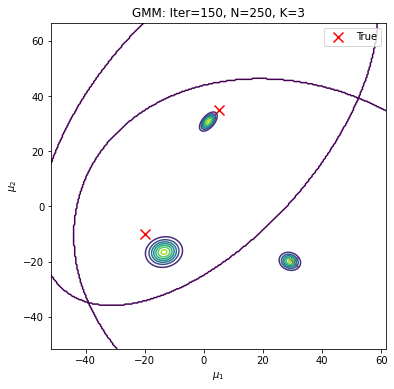

In [25]:
# muの事後分布を図で確認
# K個のガウス分布がそれぞれ真の平均付近をピークとする分布を推定できていることを確認してください。

plt.figure(figsize=(6, 6))
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], label='True', color='red', s=100, marker='x') # 真の平均
for k in range(K):
    plt.contour(mu_0_grid, mu_1_grid, posterior_density_kg[k].reshape(mu_dim)) # 事後分布
plt.title('GMM: Iter=' + str(MaxIter) + ', N=' + str(N) + ', K=' + str(K))
plt.xlabel('$\mu_1$')
plt.ylabel('$\mu_2$')
plt.legend()
plt.show()

In [26]:
# 最後の試行でサンプルしたパラメータmu_kd, lambda_ddkとpi_kを用いて、混合分布を計算

# K個のカラーマップを指定
colormap_list = ['Blues', 'Oranges', 'Greens']

# 最後にサンプルしたパラメータによる混合分布を計算
res_density = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(
        x=x_point, mean=mu_kd[k], cov=np.linalg.inv(lambda_kdd[k])
    )
    
    # K個の分布の加重平均を計算
    res_density += tmp_density * pi_k[k]

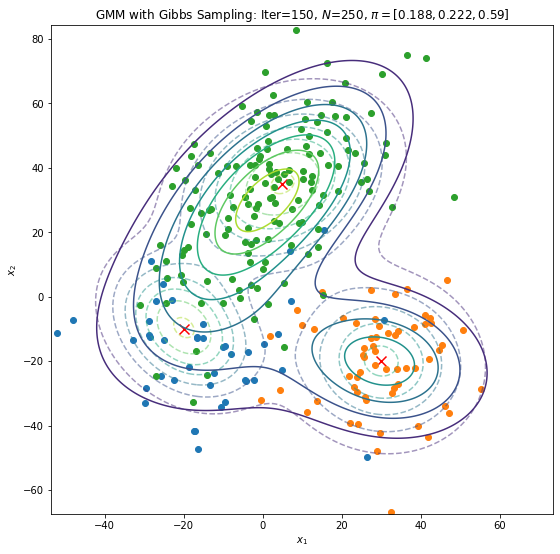

In [27]:
# 最終的な分布を作図
plt.figure(figsize=(9, 9))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), alpha=0.5, linestyles='dashed') # 真の分布
plt.scatter(x=mu_truth_kd[:, 0], y=mu_truth_kd[:, 1], color='red', s=100, marker='x') # 真の平均
plt.contour(x_1_grid, x_2_grid, res_density.reshape(x_dim)) # サンプルによる分布

for k in range(K):
    k_idx, = np.where(s_n == k)
    cm = plt.get_cmap(colormap_list[k]) # クラスタkのカラーマップを設定
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # サンプルしたクラスタ

plt.title('GMM with Gibbs Sampling: Iter=' + str(MaxIter) + ', $N$=' + str(N) + ', $\pi=[' + ', '.join([str(pi) for pi in np.round(pi_k, 3)]) + ']$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## 超パラメータの推移の確認

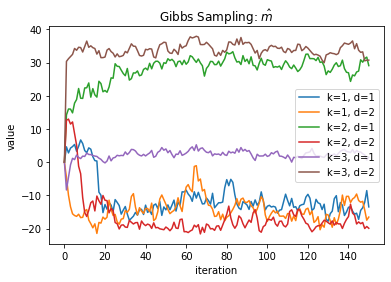

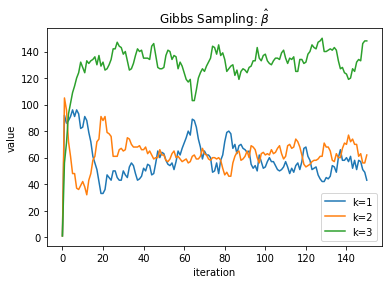

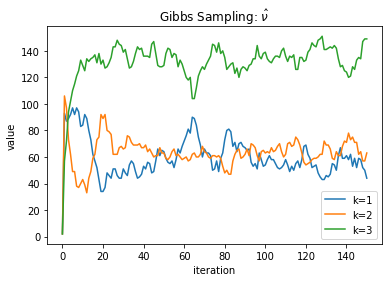

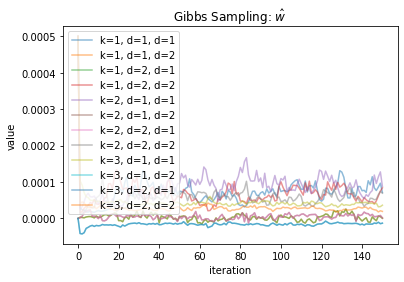

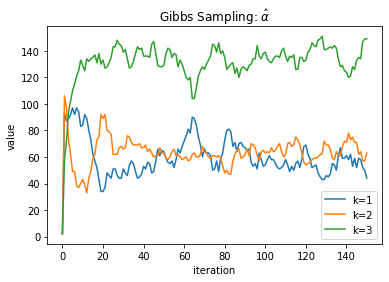

In [28]:
# mの推移を作図
plt.figure()
for k in range(K):
    for d in range(D):
        plt.plot(np.arange(MaxIter+1), np.array(trace_m_ikd)[:, k, d], 
                 label='k=' + str(k + 1) + ', d=' + str(d + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Gibbs Sampling: $\hat{m}$')
plt.legend() # 凡例
plt.show()

# betaの推移を作図
plt.figure()
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_beta_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Gibbs Sampling: $\hat{\\beta}$')
plt.legend() # 凡例
plt.show()

# nuの推移を作図
plt.figure()
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_nu_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Gibbs Sampling: $\hat{\\nu}$')
plt.legend() # 凡例
plt.show()

# wの推移を作図
plt.figure()
for k in range(K):
    for d1 in range(D):
        for d2 in range(D):
            plt.plot(np.arange(MaxIter + 1), np.array(trace_w_ikdd)[:, k, d1, d2], 
                     alpha=0.5, label='k=' + str(k + 1) + ', d=' + str(d1 + 1) + ', d''=' + str(d2 + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Gibbs Sampling: $\hat{w}$')
plt.legend() # 凡例
plt.show()

# alphaの推移を作図
plt.figure()
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_alpha_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Gibbs Sampling: $\hat{\\alpha}$')
plt.legend() # 凡例
plt.show()

## パラメータのサンプルの推移の確認

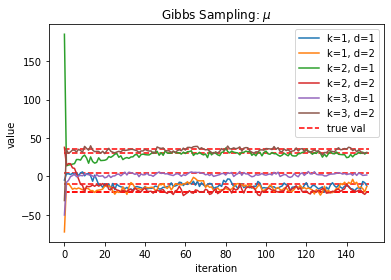

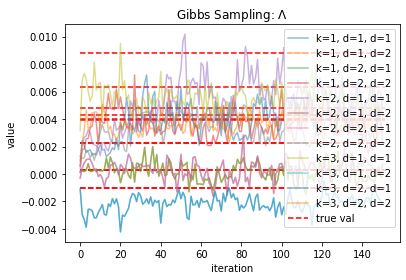

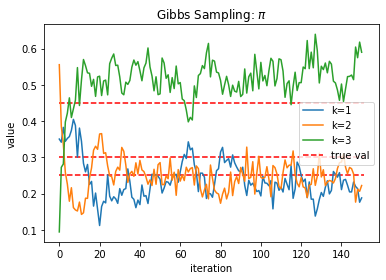

In [29]:
# muの推移を作図
plt.figure()
plt.hlines(y=mu_truth_kd, xmin=0, xmax=MaxIter + 1, label='true val', 
           color='red', linestyles='--') # 真の値
for k in range(K):
    for d in range(D):
        plt.plot(np.arange(MaxIter+1), np.array(trace_mu_ikd)[:, k, d], 
                 label='k=' + str(k + 1) + ', d=' + str(d + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Gibbs Sampling: $\mu$')
plt.legend() # 凡例
plt.show()

# lambdaの推移を作図
plt.figure()
plt.hlines(y=np.linalg.inv(sigma2_truth_kdd), xmin=0, xmax=MaxIter + 1, label='true val', 
           color='red', linestyles='--') # 真の値
for k in range(K):
    for d1 in range(D):
        for d2 in range(D):
            plt.plot(np.arange(MaxIter + 1), np.array(trace_lambda_ikdd)[:, k, d1, d2], 
                     alpha=0.5, label='k=' + str(k + 1) + ', d=' + str(d1 + 1) + ', d''=' + str(d2 + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Gibbs Sampling: $\Lambda$')
plt.legend() # 凡例
plt.show()

# piの推移を作図
plt.figure()
plt.hlines(y=pi_truth_k, xmin=0, xmax=MaxIter + 1, label='true val', 
           color='red', linestyles='--') # 真の値
for k in range(K):
    plt.plot(np.arange(MaxIter + 1), np.array(trace_pi_ik)[:, k], label='k=' + str(k + 1))
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('Gibbs Sampling: $\pi$')
plt.legend() # 凡例
plt.show()